In [1]:
# import all needed libs
import os
import pandas as pd
import numpy as np
import torch
import torchvision
from torchvision import transforms
import zipfile
import shutil
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from google.colab import drive
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from config import *
torch.manual_seed(1234)

In [2]:
class VehiclesDataset(torch.utils.data.Dataset):
    def __init__(self, metadata_df, labels2int, transform):
        self.paths = metadata_df.path.values
        self.labels = metadata_df.label.values
        self.labels2int = labels2int
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]
        x = Image.open(img_path).convert("RGB")
        x = self.transform(x)
        y = self.labels2int[label]
        return (x, y)

In [4]:
# mount google drive
drive.mount(MOUNT_DIR)

Drive already mounted at /mount_point; to attempt to forcibly remount, call drive.mount("/mount_point", force_remount=True).


In [5]:
# if you don't want to unzip data, set UNZIP_DATA to False
UNZIP_DATA = False

if UNZIP_DATA:
    
    # clean data from previous experiments
    for d in [DATA_DIR]:
        if os.path.isdir(d):
            shutil.rmtree(d)
            
    # unzip data
    with zipfile.ZipFile(os.path.join(ZIPPED_DATA_PATH), 'r') as zip_ref:
        zip_ref.extractall(ZIPPED_DATA_PATH.replace("vehicles.zip", ""))

In [6]:
def get_binary_label(label):
    if label in ["Speedboat", "RV", "Fireboat", "Amphibius_Vehicle", "Airship", "Airliner"]: return "civil"
    if label in ["Warplane", "Tank", "Submarine", "Aircraft_Carrier"]: return "war"
    
# collect metadata
metadata_dict = {k: [] for k in ["path", "label"]}
for label in os.listdir(DATA_DIR):
    for f in os.listdir(os.path.join(DATA_DIR, label)):
        metadata_dict["path"].append(os.path.join(DATA_DIR, label, f))
        metadata_dict["label"].append(get_binary_label(label))
metadata_df = pd.DataFrame(metadata_dict)
metadata_df

,path,label
0,/mount_point/MyDrive/calypsoai_challenge/vehic...,war
1,/mount_point/MyDrive/calypsoai_challenge/vehic...,war
2,/mount_point/MyDrive/calypsoai_challenge/vehic...,war
3,/mount_point/MyDrive/calypsoai_challenge/vehic...,war
4,/mount_point/MyDrive/calypsoai_challenge/vehic...,war
...,...,...
12995,/mount_point/MyDrive/calypsoai_challenge/vehic...,war
12996,/mount_point/MyDrive/calypsoai_challenge/vehic...,war
12997,/mount_point/MyDrive/calypsoai_challenge/vehic...,war
12998,/mount_point/MyDrive/calypsoai_challenge/vehic...,war


In [7]:
# here you can see that the label is well balanced
# this will be important later one
metadata_df.label.value_counts()

civil    7800
war      5200
Name: label, dtype: int64

In [8]:
# dictionary to easily go from labels to int and viceversa
label2int = {label: i for i, label in enumerate(metadata_df.label.unique())}
int2label = {i: label for label, i in label2int.items()}

# split dataset in train, valid and test sets
train_df, valid_test_df = train_test_split(metadata_df, train_size=TRAIN_SPLIT, random_state=1234)
valid_df, test_df = train_test_split(valid_test_df, train_size=0.5, random_state=1234)

In [9]:
len(train_df), len(valid_df), len(test_df)

(7800, 2600, 2600)

In [10]:
# when training do some data augmentation: e.g. color jitter, flip, etc
# here I could use lots of more data augmentation functions in order to make the model to generalize as much as possible
train_transforms = transforms.Compose([
        transforms.Resize(TARGET_SIZE),
        transforms.RandomResizedCrop(CROP_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=JITTER, contrast=JITTER, saturation=JITTER, hue=JITTER),
        transforms.RandomRotation(degrees=DEGREES),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ])

inference_transforms = transforms.Compose([
        transforms.Resize(TARGET_SIZE),
        transforms.CenterCrop(CROP_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ])

train_ds = VehiclesDataset(train_df, label2int, train_transforms)
valid_ds = VehiclesDataset(valid_df, label2int, inference_transforms)
test_ds = VehiclesDataset(test_df, label2int, inference_transforms)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), pin_memory=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), pin_memory=True)

In [11]:
# Define my model starting from a pretrained on Imagenet one
# Most the vehicles here are within the Imagenet dataset so the life of the model will be easier start from that pretrained weights
# This is for sake of semplicity
# For the same reason I use a mobilenet v2 as backbone that is a small network (so I save time during the training phase)
class FineTunedNet(torch.nn.Module):
    
    def __init__(self, num_classes):
        super(FineTunedNet, self).__init__()
        self.model = torchvision.models.mobilenet_v2(pretrained=True)
        in_features = self.model.classifier[-1].in_features
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.classifier[-1] = torch.nn.Linear(in_features=in_features, out_features=num_classes, bias=True)

    def forward(self, x):
        return self.model(x)

In [12]:
criterion = torch.nn.CrossEntropyLoss()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [13]:
# since the dataset is more or less balanced enough I'm gonna train the model having a look at the accuracy only
# again, this is for sake of simplicity
# if I had to train something more seroiuosly I probably would have taken a look at f1

def train_model(model, dataloaders, criterion, optimizer, num_epochs, device):

    min_val_loss = np.Inf
    best_model_weights = None
    history = {"loss": {"train":[], "val":[]},
               "acc":  {"train":[], "val":[]}}

    model.to(device)
    for epoch in tqdm(range(num_epochs), leave=False):
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], total=len(dataloaders[phase]), leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            history["loss"][phase].append(epoch_loss)
            history["acc"][phase].append(epoch_acc)

            if phase == 'val' and epoch_loss < min_val_loss:
                min_val_loss = epoch_loss
                best_model_weights = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_weights)

    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    axes[0].plot(np.arange(1, num_epochs+1), history["loss"]["train"], label="train")
    axes[0].plot(np.arange(1, num_epochs+1), history["loss"]["val"], label="val")
    axes[0].set_title("LOSS vs EPOCH")
    axes[1].plot(np.arange(1, num_epochs+1), history["acc"]["train"], label="train")
    axes[1].plot(np.arange(1, num_epochs+1), history["acc"]["val"], label="val")
    axes[1].set_title("ACCURACY vs EPOCH")
    axes[0].legend(); axes[1].legend()
    plt.show()
    return model, min_val_loss

lr = 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

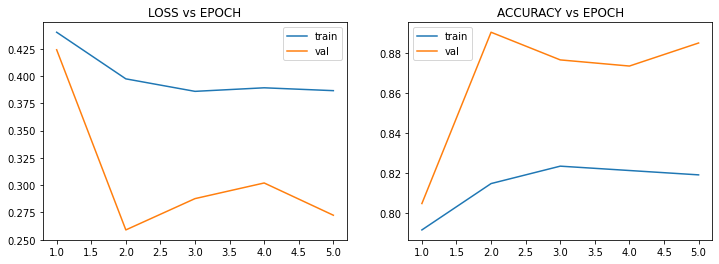



lr = 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

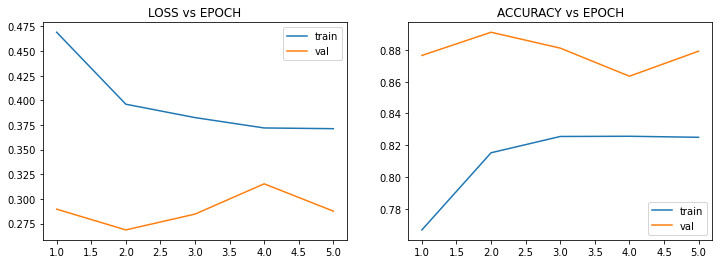

In [14]:
trained_models = []
min_val_losses = []

# I cross-validate the learning rate only but a lots of other parameters should be cross-validated in a real world scenario
for lr in LR_LIST :
    print("lr =", lr)
    model = FineTunedNet(num_classes=len(label2int)).to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
    trained_model, min_val_loss = train_model(model, {"train":train_dl, "val":valid_dl}, criterion, optimizer, N_EPOCHS, device)
    trained_models.append(trained_model)
    min_val_losses.append(min_val_loss)
    print()
    print()

In [23]:
# I test the best model in terms of lowest loss on the validation set
best_model = trained_models[np.argmin(min_val_losses)]
best_model.eval()
best_model.to(device)

# I run infernce on the test
proba = []
for inputs, _ in tqdm(test_dl, total=len(test_dl), leave=False):
    inputs = inputs.to(device)
    outputs = model(inputs)
    for output in outputs:
        proba.append(torch.sigmoid(output).cpu().detach().numpy())
proba = np.array(proba)

  0%|          | 0/82 [00:00<?, ?it/s]

In [26]:
test_df["pred"] = [np.argmax(p) for p in proba]
test_df["gt"] = [label2int[l] for l in test_df.label]
test_df["prob0"] = proba[:, 0]
test_df["prob1"] = proba[:, 1]


# I compute the classification report
# it includes precision, recall and f1 for all classs and some overall values as well
# there is also the overall accuracy and it might be a good metric to evaluate the performance of the model since classe are more or less balanced
# In order to be more precise, regardless the number of samples per class, I would use the f1 and specifically the weighted one here if I had to give you only a number to evaluate the whole model
report = classification_report(
    y_true=test_df["gt"].values,
    y_pred=test_df["pred"].values,
    target_names=[int2label[i]for i in range(len(int2label))]
)
print(report)

              precision    recall  f1-score   support

         war       0.87      0.89      0.88      1049
       civil       0.93      0.91      0.92      1551

    accuracy                           0.90      2600
   macro avg       0.90      0.90      0.90      2600
weighted avg       0.90      0.90      0.90      2600



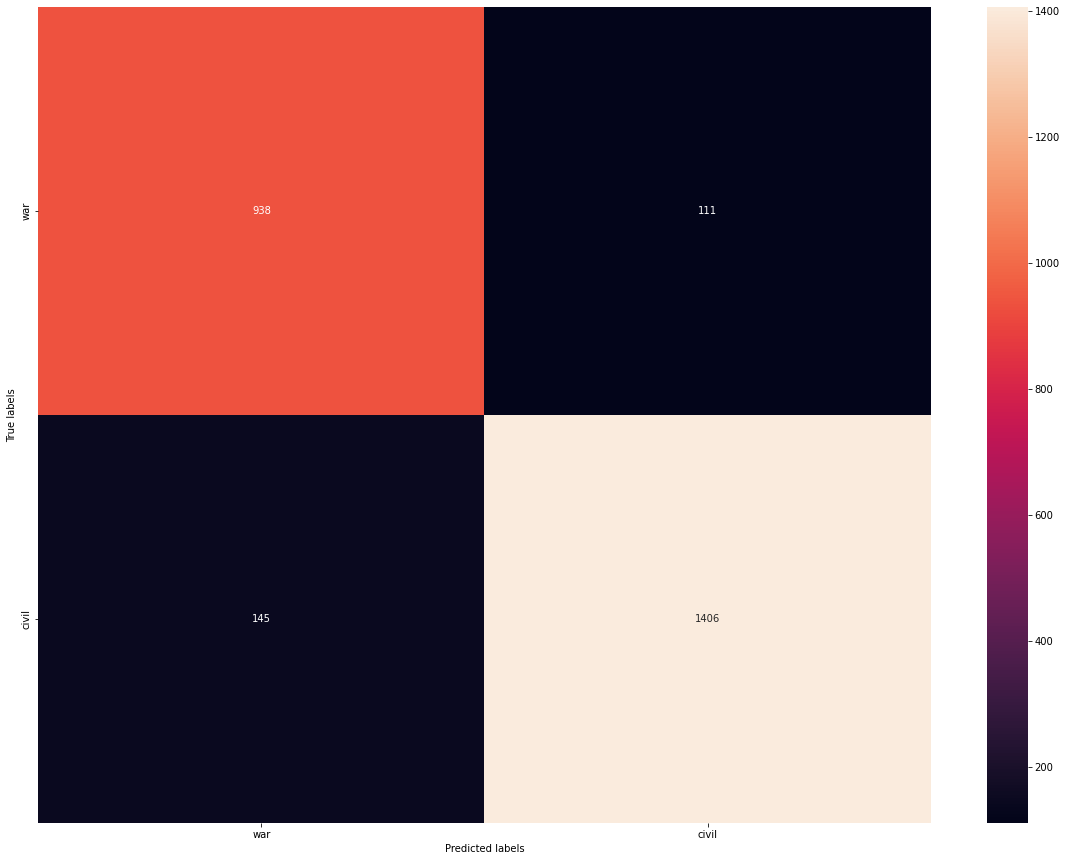

In [27]:
# here I plot the confusion matrix whihc allow us to easily see which classes make the model to make errrs the most

cm = confusion_matrix(y_true=test_df["gt"].values,
    y_pred=test_df["pred"].values)

plt.figure(figsize=(20,15))
sns.heatmap(cm, annot=True, fmt='g', ax=plt.gca())  #annot=True to annotate cells, ftm='g' to disable scientific notation

plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.gca().xaxis.set_ticklabels([int2label[i]for i in range(len(int2label))])
plt.gca().yaxis.set_ticklabels([int2label[i]for i in range(len(int2label))])

plt.show()

Actual label WAR
Predct label CIVIL


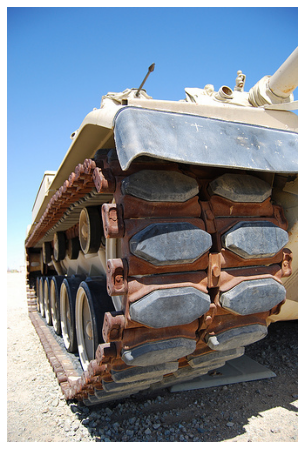



Actual label WAR
Predct label CIVIL


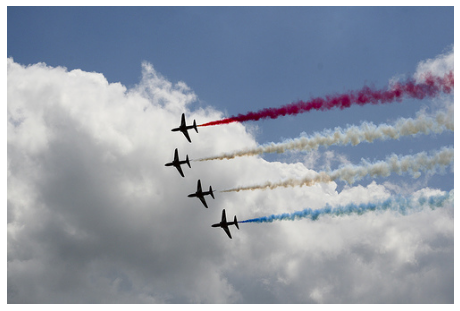



Actual label CIVIL
Predct label WAR


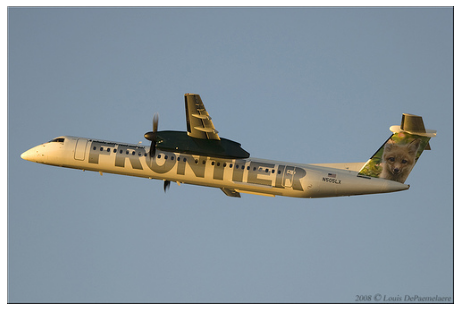



Actual label WAR
Predct label CIVIL


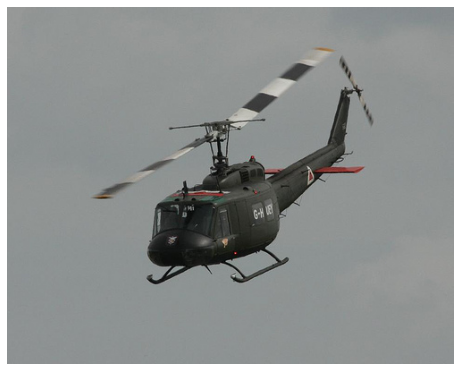



Actual label WAR
Predct label CIVIL


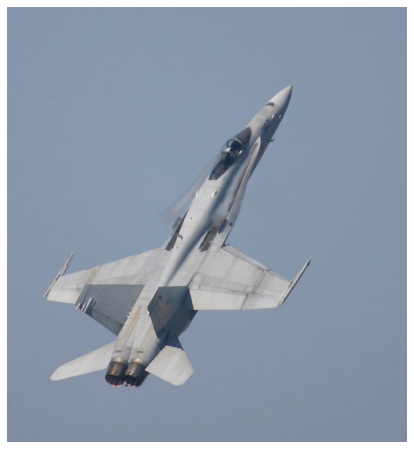



Actual label CIVIL
Predct label WAR


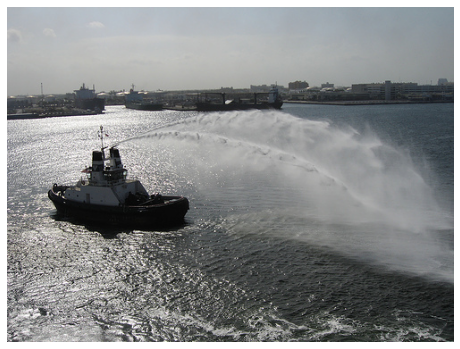



Actual label CIVIL
Predct label WAR


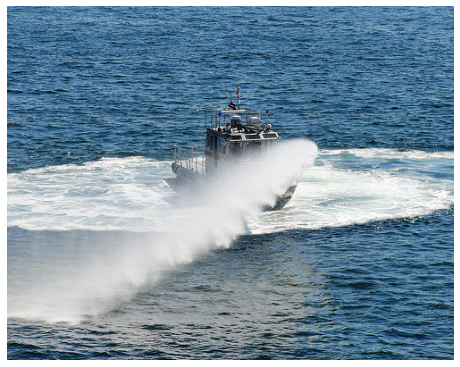



Actual label CIVIL
Predct label WAR


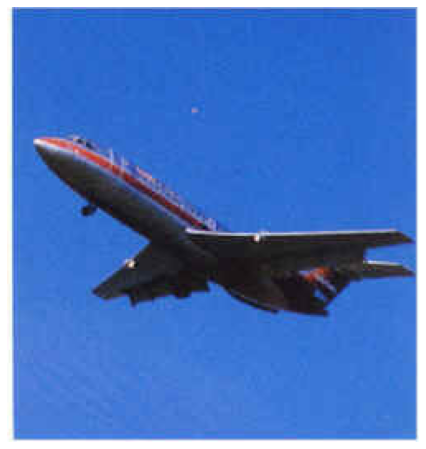



Actual label WAR
Predct label CIVIL


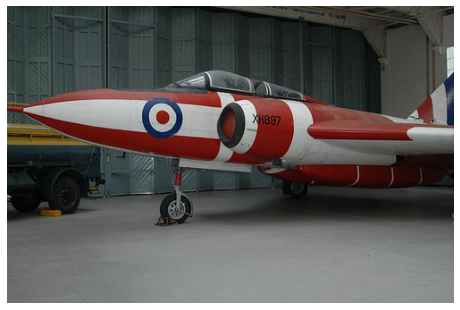



Actual label WAR
Predct label CIVIL


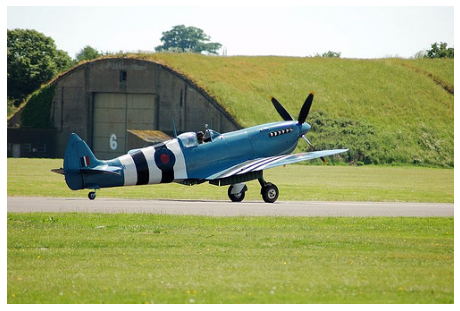

In [37]:
# let's have a look at some test samples the model is very uncertain about
for _, row in test_df.query("0.45 <= prob1 <= 0.55 and pred != gt").sample(10, random_state=1234).iterrows():
    print("Actual label", int2label[row["gt"]].upper())
    print("Predct label", int2label[row["pred"]].upper())
    plt.figure(figsize=(8,8))
    plt.imshow(plt.imread(row.path))
    plt.axis("off")
    plt.show()
    print()
    print()